In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

df = pd.read_csv("/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv")

df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import os
import cv2
from os import listdir

X = []
image_names = []
folder_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        n = cv2.imread(os.path.join(folder_dir,images))
        X.append(n)
        image_names.append(images)

In [3]:
len(X)

10015

In [4]:
df['label'] = df.iloc[:, 1:].idxmax(axis=1).map({
    'MEL': 0,
    'NV': 1,
    'BCC': 2,
    'AKIEC': 3,
    'BKL': 4,
    'DF': 5,
    'VASC': 6
})
df = df.drop(columns=['MEL','NV','BCC','AKIEC','BKL','DF','VASC'])

df.head()

,image,label
0,ISIC_0024306,1
1,ISIC_0024307,1
2,ISIC_0024308,1
3,ISIC_0024309,1
4,ISIC_0024310,0


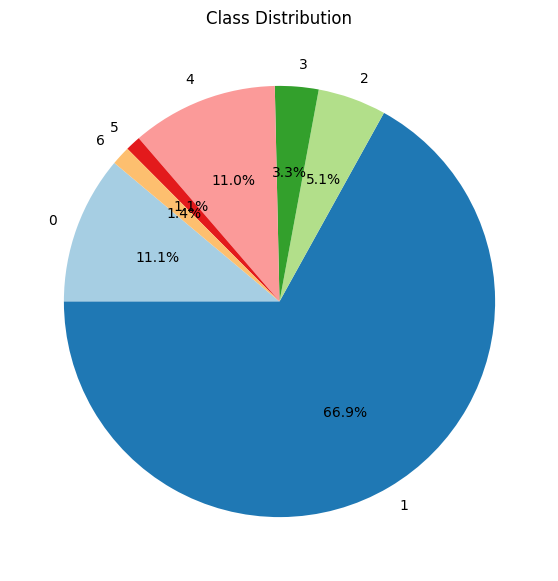

In [5]:
import matplotlib.pyplot as plt
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Class Distribution')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader,random_split

X_train, X_valid, y_train, y_valid = train_test_split(X, df["label"], test_size=0.25, random_state=42,stratify=df["label"])
X_test, X_val, y_test, y_val = train_test_split(X_valid,y_valid, test_size=0.5, random_state=42,stratify=y_valid)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm import tqdm
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn as nn

# Load the processor and ResNet model
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")

# Modify the classifier layer for 7 classes
num_classes = 7
if isinstance(model.classifier, nn.Sequential):
    # Access the last layer in the Sequential and replace it
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
else:
    # For non-Sequential classifiers
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

print(model)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Prepare data
# Assuming X_train, y_train, X_val, y_val, X_test, and y_test are available
train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    # Using tqdm for the training loop to display a progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as tepoch:
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).logits  # Access logits directly
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update the progress bar description with the loss and accuracy
            tepoch.set_postfix(loss=train_loss / (tepoch.n + 1), accuracy=100. * correct / total)

    train_accuracy = 100. * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation loop with tqdm
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(val_loader, desc="Validation", unit="batch") as vepoch:
            for inputs, labels in vepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Update the progress bar description with the loss and accuracy
                vepoch.set_postfix(loss=val_loss / (vepoch.n + 1), accuracy=100. * correct / total)

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

Epoch 1/3: 100%|██████████| 235/235 [01:39<00:00,  2.37batch/s, accuracy=65.1, loss=1.2] 


Epoch 1/3, Loss: 281.6995, Accuracy: 65.13%


Validation: 100%|██████████| 40/40 [00:11<00:00,  3.50batch/s, accuracy=66.9, loss=1.17]


Validation Loss: 46.9122, Accuracy: 66.93%


Epoch 2/3: 100%|██████████| 235/235 [01:47<00:00,  2.19batch/s, accuracy=67, loss=1.04]  


Epoch 2/3, Loss: 244.6682, Accuracy: 67.00%


Validation: 100%|██████████| 40/40 [00:11<00:00,  3.57batch/s, accuracy=66.8, loss=1.19]


Validation Loss: 47.6919, Accuracy: 66.77%


Epoch 3/3: 100%|██████████| 235/235 [01:48<00:00,  2.16batch/s, accuracy=69.6, loss=0.85] 


Epoch 3/3, Loss: 199.7905, Accuracy: 69.59%


Validation: 100%|██████████| 40/40 [00:11<00:00,  3.62batch/s, accuracy=64.9, loss=1.3] 

Validation Loss: 51.8582, Accuracy: 64.86%


Test Loss: 50.7477, Accuracy: 64.54%


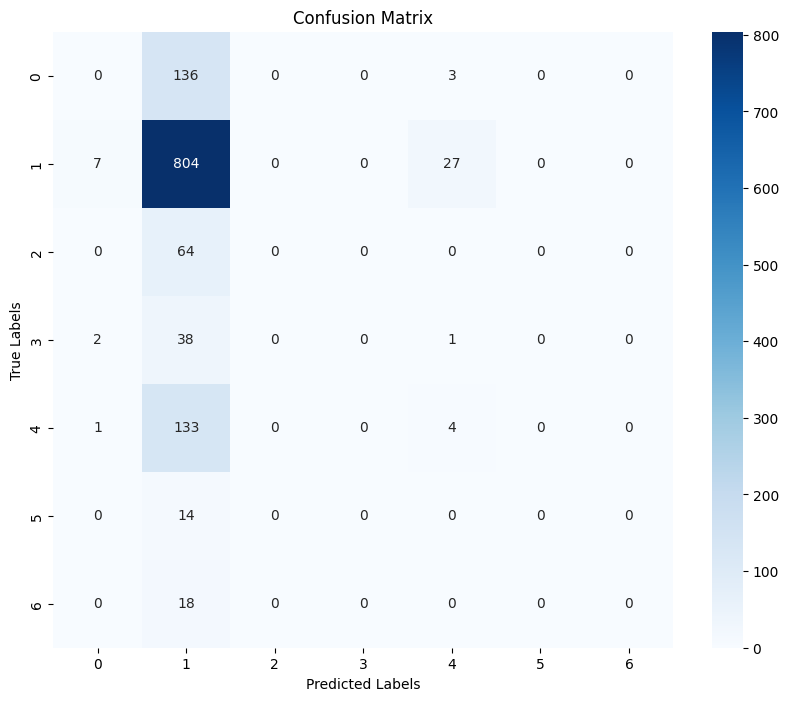

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       139
     Class 1       0.67      0.96      0.79       838
     Class 2       0.00      0.00      0.00        64
     Class 3       0.00      0.00      0.00        41
     Class 4       0.11      0.03      0.05       138
     Class 5       0.00      0.00      0.00        14
     Class 6       0.00      0.00      0.00        18

    accuracy                           0.65      1252
   macro avg       0.11      0.14      0.12      1252
weighted avg       0.46      0.65      0.53      1252



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




test_accuracy = 100. * correct / total
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

# Convert predictions and labels to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)])
print("Classification Report:")
print(class_report)

In [11]:
# Function to calculate total and trainable parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Get the total and trainable parameters
total_params, trainable_params = count_parameters(model)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 11,180,103
Trainable parameters: 11,180,103
